In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('../../churn-prediction/customers_data.csv')

In [4]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

str_cols = list(df.dtypes[df.dtypes == 'object'].index)

for col in str_cols:
    df[col] = df[col].str.lower().str.replace(" ", "_")
    
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [5]:
full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_valid = train_test_split(full_train, test_size=0.25, random_state=1)

In [6]:
y_test = df_test.churn.values
y_valid = df_valid.churn.values
y_train = df_train.churn.values

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

del df_test['churn']
del df_valid['churn']
del df_train['churn']

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[numerical + categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [9]:
valid_dict = df_valid[numerical + categorical].to_dict(orient='records')
X_valid = dv.transform(valid_dict)

prediction = model.predict_proba(X_valid)

soft_prediction = model.predict_proba(X_valid)[:, 1]

In [10]:
churn_decision = (soft_prediction >= 0.5)

(churn_decision == y_valid).mean()

0.8034066713981547

# Accuracy and dummy model

In [11]:
len(y_valid)

1409

In [12]:
(y_valid == churn_decision).sum()
# absolute value

1132

In [13]:
thresholds = np.linspace(0, 1, 21)

thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [14]:
scores = []

for t in thresholds:
    churn_decision = (soft_prediction >= t)
    score = (y_valid == churn_decision).mean()
    scores.append(score)

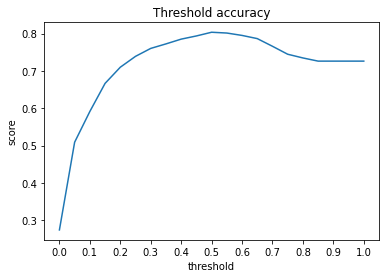

In [15]:
plt.plot(thresholds, scores)
plt.title('Threshold accuracy')
plt.xlabel('threshold')
plt.ylabel('score')

plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [16]:
# doing via sklearn
from sklearn.metrics import accuracy_score

accuracy_score(y_valid, soft_prediction >= 0.5)

0.8034066713981547

In [17]:
y_valid.mean()
# 27% are churning

0.2739531582682754

In [18]:
1 - y_valid.mean()
# 72% are non-churning

0.7260468417317246

In [19]:
length = len(y_valid)
baseline = np.repeat(False, length)

In [20]:
round(accuracy_score(baseline, y_valid, ), 3)

0.726

# Confusion table

In [21]:
actual_positive = (y_valid == 1)
actual_negative = (y_valid == 0)

In [22]:
t = 0.5

prediction_positive = (soft_prediction >= t)
prediction_negative = (soft_prediction < t)

In [23]:
true_positive = (actual_positive & prediction_positive).sum()
true_negative = (actual_negative & prediction_negative).sum()

false_positive = (actual_negative & prediction_positive).sum()
false_negative = (actual_positive & prediction_negative).sum()

In [24]:
               # predictions
          # neg              pos
c_t = np.array([
        [true_negative, false_positive],    # neg   # actual values
        [false_negative, true_positive]     # pos
])                
                 

In [25]:
c_t
# false_positive is when customer doesn't churn, but we predict as churn
# false_negative is when customer does churn, but we predict as no-churn

array([[922, 101],
       [176, 210]])

In [26]:
c_t * 100 / c_t.sum()
# normalize it -> get relative numbers

array([[65.43647977,  7.1682044 ],
       [12.49112846, 14.90418737]])

In [27]:
# we can get our accuracy from confusion table
(65.43647977 + 14.90418737) / (65.43647977 + 14.90418737 + 12.49112846 + 7.1682044)

0.8034066714000001

# Precision and Recall

In [28]:
p = 210 / (101 + 210)

In [29]:
p
# 33% are mistaken customers who are not supposed to get email

0.6752411575562701

In [30]:
r = 210 / (210 + 176)

In [31]:
r
# so, 46% of churning customers are not identified

0.5440414507772021

# ROC Curve

In [33]:
tpr = true_positive / (true_positive + false_negative)
fpr = false_positive / (false_positive + true_negative)

In [34]:
tpr

0.5440414507772021

In [35]:
fpr

0.09872922776148582

In [36]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_valid == 1)
    actual_negative = (y_valid == 0)
    
    prediction_positive = (soft_prediction >= t)
    prediction_negative = (soft_prediction < t)
    
    true_positive = (actual_positive & prediction_positive).sum()
    true_negative = (actual_negative & prediction_negative).sum()

    false_positive = (actual_negative & prediction_positive).sum()
    false_negative = (actual_positive & prediction_negative).sum()
    
    scores.append((t, true_positive, true_negative,
                   false_positive, false_negative))

In [40]:
columns = ['t', 'tp', 'tn', 'fp', 'fn']

df_small = pd.DataFrame(scores)
df_small.columns = columns

In [42]:
df_small[::10]

,t,tp,tn,fp,fn
0,0.0,386,0,1023,0
10,0.1,366,467,556,20
20,0.2,333,667,356,53
30,0.3,284,787,236,102
40,0.4,249,857,166,137
50,0.5,210,922,101,176
60,0.6,150,970,53,236
70,0.7,76,1003,20,310
80,0.8,13,1022,1,373
90,0.9,0,1023,0,386


In [49]:
df_small['tpr'] = df_small.tp / (df_small.tp + df_small.fn)
df_small['fpr'] = df_small.fp / (df_small.fp + df_small.tn)

In [50]:
df_small[::10]

,t,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,366,467,556,20,0.948187,0.543500
20,0.2,333,667,356,53,0.862694,0.347996
30,0.3,284,787,236,102,0.735751,0.230694
40,0.4,249,857,166,137,0.645078,0.162268
50,0.5,210,922,101,176,0.544041,0.098729
60,0.6,150,970,53,236,0.388601,0.051808
70,0.7,76,1003,20,310,0.196891,0.019550
80,0.8,13,1022,1,373,0.033679,0.000978
90,0.9,0,1023,0,386,0.000000,0.000000


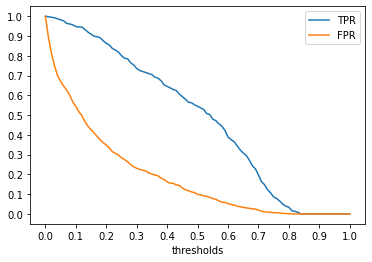

In [55]:
plt.plot(df_small.t, df_small['tpr'], label='TPR')
plt.plot(df_small.t, df_small['fpr'], label='FPR')

plt.xlabel('thresholds')

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.legend()
plt.show()

# Random model

In [66]:
# make model that randomly predicts churn/non-churn
np.random.seed(1)

y_rand = np.random.uniform(0, 1, size=len(y_valid))

In [67]:
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [68]:
((y_rand >= 0.5) == y_valid).mean()

0.5017743080198722

In [69]:
def tpr_fpr_score(y_valid, soft_prediction):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_valid == 1)
        actual_negative = (y_valid == 0)

        prediction_positive = (soft_prediction >= t)
        prediction_negative = (soft_prediction < t)

        true_positive = (actual_positive & prediction_positive).sum()
        true_negative = (actual_negative & prediction_negative).sum()

        false_positive = (actual_negative & prediction_positive).sum()
        false_negative = (actual_positive & prediction_negative).sum()

        scores.append((t, true_positive, true_negative,
                       false_positive, false_negative))
        
    
    columns = ['t', 'tp', 'tn', 'fp', 'fn']

    df_small = pd.DataFrame(scores, columns=columns)
    df_small['tpr'] = df_small.tp / (df_small.tp + df_small.fn)
    df_small['fpr'] = df_small.fp / (df_small.fp + df_small.tn)

    return df_small

In [70]:
df_rand = tpr_fpr_score(y_valid, y_rand)

In [72]:
df_rand[::10]

,t,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,347,100,923,39,0.898964,0.902248
20,0.2,307,201,822,79,0.795337,0.803519
30,0.3,276,299,724,110,0.715026,0.707722
40,0.4,237,399,624,149,0.613990,0.609971
50,0.5,202,505,518,184,0.523316,0.506354
60,0.6,161,614,409,225,0.417098,0.399804
70,0.7,121,721,302,265,0.313472,0.295210
80,0.8,78,817,206,308,0.202073,0.201369
90,0.9,40,922,101,346,0.103627,0.098729


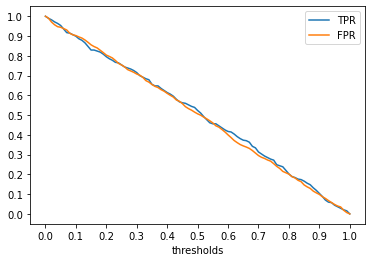

In [73]:
plt.plot(df_rand.t, df_rand['tpr'], label='TPR')
plt.plot(df_rand.t, df_rand['fpr'], label='FPR')

plt.xlabel('thresholds')

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.legend()
plt.show()

# Ideal model

In [79]:
num_neg = (y_valid == 0).sum()
num_pos = (y_valid == 1).sum()
num_neg, num_pos

(1023, 386)

In [81]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_pred = np.linspace(0, 1, num_neg + num_pos)
df_ideal = tpr_fpr_score(y_ideal, y_pred)

![title](roc.jpg)

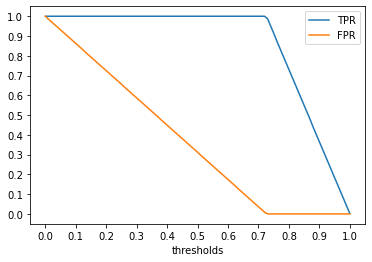

In [82]:
plt.plot(df_ideal.t, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.t, df_ideal['fpr'], label='FPR')

plt.xlabel('thresholds')

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.legend()
plt.show()

In [88]:
((y_pred >= 0.726) == y_ideal).mean()
# 0.72 as we see from the graph is the point where
# all non-churning and all churning are classified
# correctly

1.0

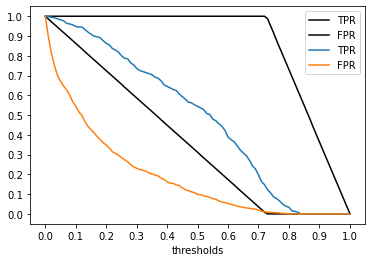

In [91]:
plt.plot(df_ideal.t, df_ideal['tpr'], label='TPR', color='black')
plt.plot(df_ideal.t, df_ideal['fpr'], label='FPR', color='black')

# plt.plot(df_rand['fpr'], df_rand['tpr'], label='Rand')
plt.plot(df_small.t, df_small['tpr'], label='TPR')
plt.plot(df_small.t, df_small['fpr'], label='FPR')

plt.xlabel('thresholds')

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.legend()
plt.show()
# We want TPR to be as close to ideal TPR

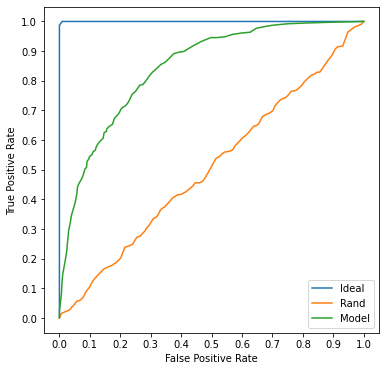

In [93]:
plt.figure(figsize=(6,6))

plt.plot(df_ideal['fpr'], df_ideal['tpr'], label='Ideal')
plt.plot(df_rand['fpr'], df_rand['tpr'], label='Rand')
plt.plot(df_small['fpr'], df_small['tpr'], label='Model')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.legend()
plt.show()